In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from pprint import pprint
import csv
import random
import requests, re, json
import matplotlib.pyplot as plt
import streamlit as st
from ipywidgets import VBox, HBox, Tab, HTML, Layout, widgets
from IPython.display import display, clear_output

In [2]:
# Note to self: add documentation.
def datareader(club_name, season):

    # Read in CSV files
    # game_lineups.csv is too large to upload to GitHub ~ work around?
    transfers_df = pd.read_csv('transfers.csv')
    games_df = pd.read_csv('games.csv')
    lineups_df = pd.read_csv('game_lineups.csv')

    # Filter transfers for given club and season -- make a deep copy of df
    club_transfers = transfers_df[(transfers_df['to_club_name'] == club_name) & (transfers_df['transfer_season'] == season)].copy()

    if club_transfers.empty:
        print(f"No transfers found for {club_name} in {season} season.")
        return pd.DataFrame()

    # Get club_id
    club_id = club_transfers['to_club_id'].iloc[0]

    # Get club's final table position after Matchday 38 in GB1
    season_year = int(season.split('/')[0]) + 2000
    club_games = games_df[(games_df['home_club_id'] == club_id) | (games_df['away_club_id'] == club_id)].copy()
    club_games = club_games[(club_games['season'] == season_year) & (club_games['competition_id'] == 'GB1') & (club_games['round'] == '38. Matchday')]
    if not club_games.empty:
        if club_games['home_club_id'].iloc[0] == club_id:
            position = club_games['home_club_position'].iloc[0]
        else:
            position = club_games['away_club_position'].iloc[0]
    else:
        print(f"No matching data found for {club_name} in {season} season.")
        position = np.nan

    # Calculate trasnfers' starting percentages
    club_lineups = lineups_df[lineups_df['club_id'] == club_id].copy()
    player_appearances = club_lineups.groupby('player_id').agg(total_appearances=('type', 'count'),starting_appearances=
                                                                   ('type', lambda x: (x == 'starting_lineup').sum()))
    player_appearances['starting_percentage'] = (player_appearances['starting_appearances'] / player_appearances['total_appearances'] * 100).round(2)

    # Create final dataframe
    result_df = club_transfers[['player_id', 'transfer_fee', 'market_value_in_eur']].copy()
    result_df.loc[:, 'club_id'] = club_id
    result_df.loc[:, 'club_position'] = position

    # Now merge with starting percentages
    result_df = result_df.merge(
        player_appearances[['starting_percentage']],
        left_on='player_id',
        right_index=True,
        how='left'
    )
    result_df.loc[:, 'starting_percentage'] = result_df['starting_percentage'].fillna(0) # Convert null values to zero

    return result_df

In [3]:
# Example usage
club_name = "Wolves"
season = "18/19"
df = datareader(club_name, season)
print(df)

       player_id  transfer_fee  market_value_in_eur  club_id  club_position  \
41999     233124           0.0            1000000.0      543            7.0   
42270     361254           0.0            3000000.0      543            7.0   
42987     175446    21000000.0           12000000.0      543            7.0   
43699     180843           0.0             500000.0      543            7.0   
44724     168157           0.0           17000000.0      543            7.0   
44746     525247     4750000.0                  NaN      543            7.0   
44757     204103    20000000.0            8000000.0      543            7.0   
45038     175446           0.0           12000000.0      543            7.0   
45083      29364     5600000.0           10000000.0      543            7.0   
45604      45026    18000000.0           16000000.0      543            7.0   
45743     142310    12000000.0            5000000.0      543            7.0   
45839     206040           0.0           15000000.0 

In [4]:
def transfer_spending_bargraph(club_names, seasons):
    # Read in csv -- change later?
    transfers_df = pd.read_csv('transfers.csv')

    # Fig and bar dimensions
    plt.figure(figsize=(12, 8))
    bar_width = 0.15

    # Set up positions for bars
    x = np.arange(len(seasons))

    for i, club in enumerate(club_names):
        avg_spent_per_transfer = []

        for season in seasons:
            # Filter transfers for the given club and season
            club_transfers = transfers_df[(transfers_df['to_club_name'] == club) &
                                       (transfers_df['transfer_season'] == season)]

            if not club_transfers.empty:
                total_value = club_transfers['market_value_in_eur'].sum() + club_transfers['transfer_fee'].sum()
                num_transfers = len(club_transfers)
                avg_value = total_value / num_transfers
                avg_spent_per_transfer.append(avg_value)
            else:
                avg_spent_per_transfer.append(0)

        # Plot bars for this club
        plt.bar(x + i * bar_width, avg_spent_per_transfer,
                bar_width, label=club)

        # Add value labels on top of bars -- maybe put final table positions here as well?
        for idx, value in enumerate(avg_spent_per_transfer):
            if value > 0:
                plt.text(x[idx] + i * bar_width, value,
                        f'{value/1000000:.1f}M',
                        ha='center', va='bottom')

    # Customize the plot
    plt.xlabel('Season')
    plt.ylabel('Average Spending per Transfer (in €)')
    plt.title('Average Spending Per Transfer by Season')
    plt.xticks(x + bar_width/2, seasons)
    plt.legend()

    plt.tight_layout()
    plt.show()

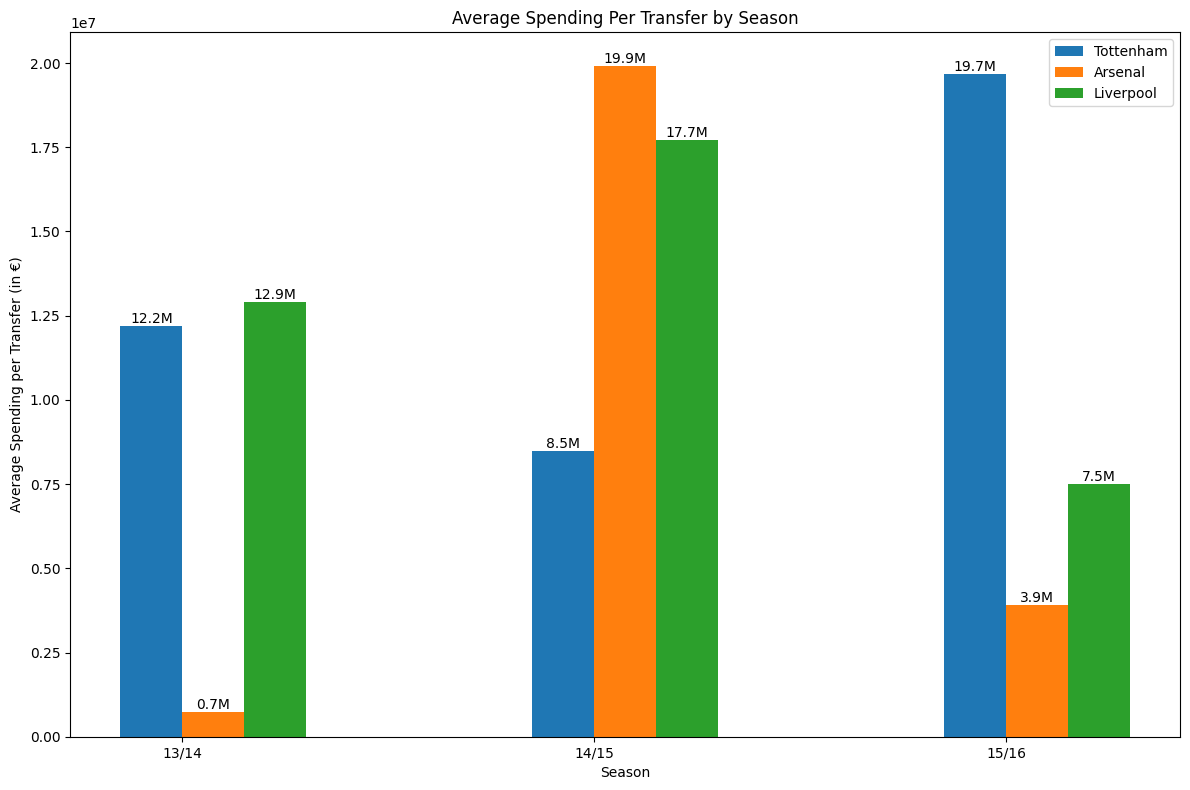

In [5]:
# Example usage
club_names = ["Tottenham", "Arsenal", "Liverpool"]
seasons = ["13/14", "14/15", "15/16"]

transfer_spending_bargraph(club_names, seasons)

In [6]:
def create_position_table(club_names, seasons):
    # Create dictionary to store positions
    positions = {season: {} for season in seasons}

    # Fill the dictionary with positions for each club and season
    for club in club_names:
        for season in seasons:
            # Get data using abc() function
            df = datareader(club, season)

            if not df.empty:
                # Get the club position from the data
                position = df['club_position'].iloc[0]
                positions[season][club] = position
            else:
                positions[season][club] = 'N/A'

    # Convert dictionary to DataFrame
    position_table = pd.DataFrame(positions)

    # Format the table
    position_table = position_table.fillna('N/A') # make table more visually appealing?

    return position_table

In [7]:
# Example usage
club_names = ["Brighton", "Arsenal"]
seasons = ["16/17", "17/18", "18/19"]

table = create_position_table(club_names, seasons)
print(table)

No matching data found for Brighton in 16/17 season.
         16/17  17/18  18/19
Brighton   N/A   15.0   17.0
Arsenal    5.0    6.0    5.0


In [ ]:
# Create output widgets
output_data = widgets.Output()  # Output widget for data display
output_graph = widgets.Output()  # Output widget for graph display

# Header
header = HTML(
    """
    <div style="
        text-align: center;
        background: linear-gradient(to right, #003366, #00509e);
        color: white;
        padding: 20px;
        border-radius: 10px;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
    ">
        <h1 style="margin: 0; font-size: 2.5em; font-family: Arial, sans-serif;">
            Football Transfer Analysis
        </h1>
        <p style="margin: 10px 0 0; font-size: 1.2em; font-family: 'Arial', sans-serif;">
            Dive deep into Premier League transfer data, visualized with powerful insights.
        </p>
    </div>
    """,
    layout=Layout(margin="10px")
)

# Inputs
club_name = widgets.Combobox(
    placeholder="Type or select a club",
    options=[
        'Tottenham', 'Arsenal', 'Liverpool', 'Wolves', 'Chelsea', 'Crystal Palace',
        'Nottm Forest', 'Man Utd', 'Man City', 'Southampton', 'Leicester', 'Ipswich',
        'Aston Villa', 'Brighton', 'Newcastle', 'Fulham', 'Brentford', 'Bournemouth',
        'Everton', 'West Ham'
    ],
    description="Club:",
    ensure_option=True,  # Prevent invalid inputs
    layout=Layout(width='300px')
)
season = widgets.Text(
    value='18/19',
    placeholder='Enter season (e.g., 18/19)',
    description='Season:',
    style={'description_width': 'initial'},
    layout=Layout(width='200px')
)
analyze_button = widgets.Button(
    description='Analyze Transfers',
    button_style='success',
    layout=Layout(width='200px', height='40px')
)

def analyze_transfers(b):
    with output_data:
        clear_output(wait=True)
        print(f"Analyzing transfers for {club_name.value} in season {season.value}...")
        try:
            df = datareader(club_name.value, season.value)  # Your function
            if not df.empty:
                display(df)
            else:
                print(f"No transfers found for {club_name.value} in {season.value} season.")
        except Exception as e:
            print(f"Error: {e}")

analyze_button.on_click(analyze_transfers)

# Graph Inputs
clubs = widgets.SelectMultiple(
    options=['Tottenham', 'Arsenal', 'Liverpool', 'Wolves', 'Chelsea', 'Crystal Palace', 'Nottm Forest', 'Man Utd', 'Man City', 'Southampton', 'Leicester', 'Ipswich', 'Aston Villa', 'Brighton', 'Newcastle', 'Fulham', 'Brentford', 'Bournemouth', 'Everton', 'West Ham'],
    value=['Tottenham', 'Arsenal', 'Liverpool', 'Wolves', 'Chelsea', 'Crystal Palace', 'Nottm Forest', 'Man Utd', 'Man City', 'Southampton', 'Leicester', 'Ipswich', 'Aston Villa', 'Brighton', 'Newcastle', 'Fulham', 'Brentford', 'Bournemouth', 'Everton', 'West Ham'],
    description='Clubs:',
    style={'description_width': 'initial'},
    layout=Layout(width='300px', height='120px')
)
seasons = widgets.SelectMultiple(
    options=['13/14', '14/15', '15/16', '16/17', '17/18'],
    value=['13/14', '14/15', '15/16', '16/17', '17/18'],
    description='Seasons:',
    style={'description_width': 'initial'},
    layout=Layout(width='300px', height='120px')
)
bargraph_button = widgets.Button(
    description='Generate Bar Graph',
    button_style='info',
    layout=Layout(width='200px', height='40px')
)

def generate_bargraph(b):
    with output_graph:
        clear_output(wait=True)
        print(f"Generating bar graph for {list(clubs.value)} in seasons {list(seasons.value)}...")
        # Replace with your transfer_spending_bargraph function call
        # Example placeholder logic:
        try:
            transfer_spending_bargraph(list(clubs.value), list(seasons.value))  # Your function
        except Exception as e:
            print(f"Error: {e}")

bargraph_button.on_click(generate_bargraph)

# Layout sections
inputs_section = HBox([club_name, season], layout=Layout(justify_content='space-between', padding='10px'))
ui_data = VBox([inputs_section, analyze_button, output_data], layout=Layout(background_color='#f9f9f9', padding='10px'))
ui_graph = VBox([clubs, seasons, bargraph_button, output_graph], layout=Layout(background_color='#f9f9f9', padding='10px'))

# Tabs
tab = Tab(children=[ui_data, ui_graph])
tab.set_title(0, "Analyze Transfers")
tab.set_title(1, "Transfer Bar Graph")

# Display
display(VBox([header, tab]))

